In [1]:
# X Kernel Density Estimation

# Density Estimator nehmen einen D-Dimensionalen Datensatz und erstellen eine D-Dimensionale Wahrscheinlichkeitsverteilung
# von der die Daten gezogen wurden
# >> GMM tut dies, indem es die Dichte als eine gewichtete Summe von Gaussian Verteilungen versteht
# >> Kernel Density treibt diesen Gedanken bis ins Extreme und nutzt eine Gaussische Verteilung pro Punkt, was eine 
#    nicht-parametrische Dichteschätzung ermöglicht

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns; sns.set()

Summe: 1.0


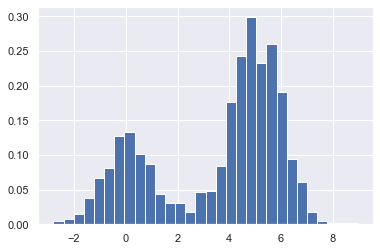

In [4]:
# Motiation von KDEs
# ... ein Beispiel für die eindimensionale Schätzung von Dichte findet sich im Histogramm

# Generieren von zufälligen Daten von zwei Normalverteilungen
def make_data(N, f=0.3, rseed=1):
    rand = np.random.RandomState(rseed)
    x = rand.randn(N)
    x[int(f * N):] += 5
    return x

x = make_data(1000)

# Erstellen des Hsitogramms
hist = plt.hist(x, bins=30, density=True) 
# >> Mit der Normalisierung ist der Inhalt unter der Kurver = 1
# Beweis
density, bins, patches = hist
widths = bins[1:] - bins[:-1]
print("Summe:", (density * widths).sum())

# Ein Problem des Histogramms als ein Verfahren für die Schätzung der Dichte ist, dass die Wahl von Bins und Location (?)
# einen Einfluss auf die Schätzung haben...

[-5.         -3.33333333 -1.66666667  0.          1.66666667  3.33333333
  5.          6.66666667  8.33333333 10.        ]


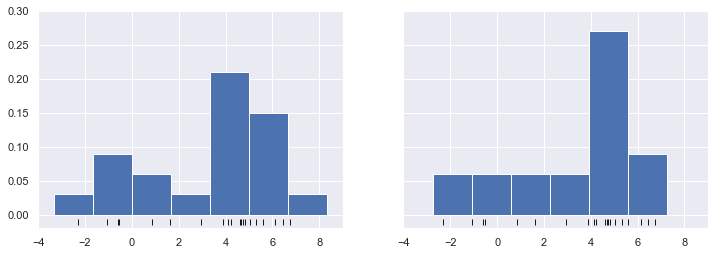

In [6]:
# Beispiel der Daten mit 20 Punkten
x = make_data(20)

bins = np.linspace(-5, 10, 10)

fig, ax = plt.subplots(1, 2, figsize=(12, 4),
                       sharex=True, sharey=True,
                      subplot_kw=dict(xlim=(-4, 9), ylim=(-0.02, 0.3)))

# Ersteööen der Histogramme mit unterschiedlicher Bin-Größe
for i, offset in enumerate([0.0, 0.6]):
    ax[i].hist(x, bins=bins + offset, density=True)
    ax[i].plot(x, np.full_like(x, -0.01), '|k',
              markeredgewidth=1)
    
# >> Während das Linke Histogramm die bimodale Verteilung widerspiegelt, findet sich in der rechten Verteilung
#    nur ein Höhepunkt... Damit ist die Ausgabe des Histogramms nicht vertrauenswürdig für die Schätzung der Dichte

(-0.2, 8.0)

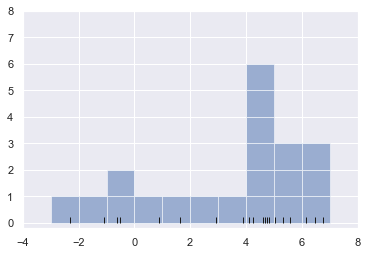

In [31]:
# Wie kann dies verbessert werden?

# Ein Histogramm kann auch als ein Turm von aufeinandergesetzten Quadraten verstanden werden
# Siehe Plot

fig, ax = plt.subplots()
bins = np.arange(-3, 8)

ax.plot(x, np.full_like(x, 0.1), "|k",
       markeredgewidth=1)
# Visualisiert die Punkte

for count, edge in zip(*np.histogram(x, bins)):
    for i in range(count):
        ax.add_patch(plt.Rectangle((edge, i), 1, 1,
                                  alpha=0.5))
# Visualisiert die Blöcke
ax.set_xlim(-4, 8)
ax.set_ylim(-0.2, 8)

# Das Problem von Histogrammen ist, dass sie Ausschläge nicht zwangsweise die Dichte der Punkte in ihrer Umgebung reflektieren,
# sondern machnmal (wie hier) stark von diesen abweichen

(-4.0, 8.0, -0.2, 8.0)

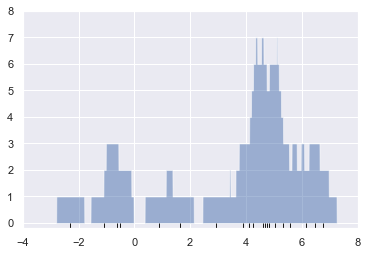

In [38]:
# Statt die Blocks mit den Bins zu alignen, wäre es also möglich diese mit den eigentlichen Punkten zu alignen
x_d = np.linspace(-4, 8, 2000)
density = sum((abs(xi - x_d) < 0.5) for xi in x)

plt.fill_between(x_d, density, alpha=0.5)
plt.plot(x, np.full_like(x, -0.1), '|k', markeredgewidth=1)
plt.axis([-4, 8, -0.2, 8])

# Das ERgebnis ist etwas messy aber eine deutlich bessere Repräsentation der Daten als das Histogram zuvor

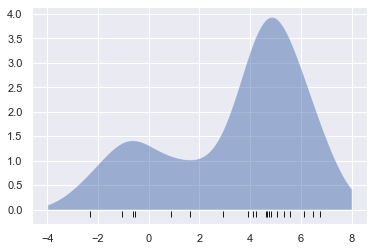

In [10]:
from scipy.stats import norm

# Um die Darstellung zu verschönern, wird die Graphik gesmoothed mit einer Gaussischen Verteilung
x_d = np.linspace(-4, 8, 1000)
# Smoothen der Dichte mit der gaussischen Normalverteilung...
density = sum(norm(xi).pdf(x_d) for xi in x)

plt.fill_between(x_d, density, alpha=0.5)
plt.plot(x, np.full_like(x, -0.1), '|k', markeredgewidth=1)

plt.axis = [-4, 8, -0.2, 5]


(-0.02, 0.22)

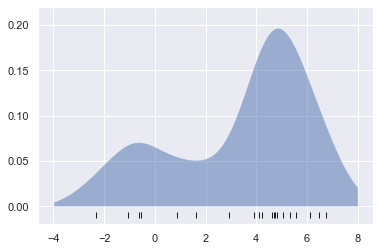

In [12]:
# KDE in Practice
# Die letzten beiden Plots sind ein Beispiel für Kernel Density Estimators
# >> der erste entspricht einem top-hat Kernel
# >> der zweite einem gaussian Kernel

# Die Parameter eine KDE sind:
# - der Kernel, der die Verteilung an jedem Punkt spezifiziert
#   (6 verschiede Kernel in SCikitLearn KDE möglich, siehe DOC)
# - die Kernel bandwidth, der die Größe des Kernels an jedem Punkt kontrolliert

from sklearn.neighbors import KernelDensity

# instantiate + fit model
kde = KernelDensity(bandwidth=1, kernel='gaussian')
kde.fit(x[:, None])

# score samples
logprob = kde.score_samples(x_d[:, None])

plt.fill_between(x_d, np.exp(logprob), alpha=0.5)
plt.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)
plt.ylim(-0.02, 0.22)

# Das Ergebnis ist eine normalisierte Kurve, wie der Plot zuvor

{'bandwidth': 1.1233240329780276}


(-0.02, 0.22)

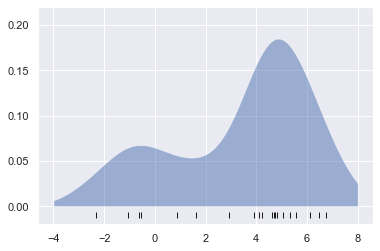

In [22]:
# Bandweite mit Crossvalidierung bestimmen
# Die richtige Bandweite zu bestimmen ist die Herausforderung in KDEs
# >> Zu hohe Bandweite führt zu underfitting, da die Struktur der Daten verwaschen wird
# >> Eine zu kleine Bandweite führ zu Overfittung

from sklearn.model_selection import GridSearchCV, LeaveOneOut

# 100 Bandweiten zwischen 0 und 10
bandwidths = 10 ** np.linspace(-1, 1, 100)

grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                   {'bandwidth': bandwidths},
                   cv=LeaveOneOut()) # Leave one Out minimiert die Reduzierung des Trainingsets für die Cross-Validierung
grid.fit(x[:, None])


# Finde besten Parameter
print(grid.best_params_)

# instantiate + fit model
kde = KernelDensity(bandwidth=1.1233240329780276, kernel='gaussian')
kde.fit(x[:, None])

# score samples
logprob = kde.score_samples(x_d[:, None])

plt.fill_between(x_d, np.exp(logprob), alpha=0.5)
plt.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)
plt.ylim(-0.02, 0.22)

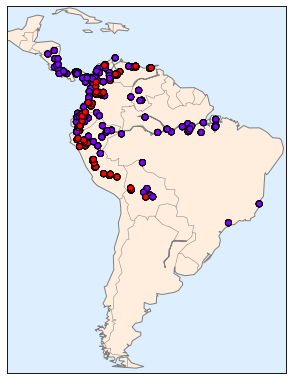

In [64]:
# Anwendungsbeispiel KDE auf Sphere
from sklearn.datasets import fetch_species_distributions

data = fetch_species_distributions()
# Datensatz über Tierarten und Koordianten
# Extrahieren der Koordinaten
latlon = np.vstack([data.train['dd lat'],
                  data.train["dd long"]]).T
# Extrahieren der Species
species = np.array([d.decode('ascii').startswith('micro')
                   for d in data.train['species']], dtype='int')


# Plotten der Geographischen Verteilung mti toolkits
from mpl_toolkits.basemap import Basemap

# von sklearn kopierter Code
def construct_grids(batch):
    """Construct the map grid from the batch object

    Parameters
    ----------
    batch : Batch object
        The object returned by :func:`fetch_species_distributions`

    Returns
    -------
    (xgrid, ygrid) : 1-D arrays
        The grid corresponding to the values in batch.coverages
    """
    # x,y coordinates for corner cells
    xmin = batch.x_left_lower_corner + batch.grid_size
    xmax = xmin + (batch.Nx * batch.grid_size)
    ymin = batch.y_left_lower_corner + batch.grid_size
    ymax = ymin + (batch.Ny * batch.grid_size)

    # x coordinates of the grid cells
    xgrid = np.arange(xmin, xmax, batch.grid_size)
    # y coordinates of the grid cells
    ygrid = np.arange(ymin, ymax, batch.grid_size)

    return (xgrid, ygrid)

xgrid, ygrid = construct_grids(data)

# plot coastlines with Basemap
fig = plt.figure(figsize=(5, 12))
m = Basemap(projection='cyl', resolution='c',
           llcrnrlat=ygrid.min(), urcrnrlat=ygrid.max(),
           llcrnrlon=xgrid.min(), urcrnrlon=xgrid.max())
m.drawmapboundary(fill_color='#DDEEFF')
m.fillcontinents(color='#FFEEDD')
m.drawcoastlines(color='gray', zorder=2)
m.drawcountries(color='gray', zorder=2)

# plot locations
m.scatter(latlon[:,1], latlon[:,0], zorder=3, edgecolors='black',
         c=species, cmap='rainbow', latlon=True)

# Etwas undeutlich, da die Punkte überlappen

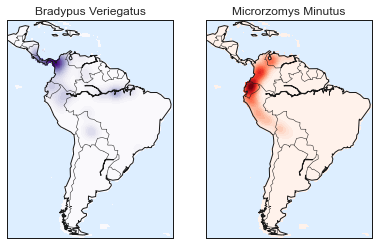

In [88]:
X, Y = np.meshgrid(xgrid[::5], ygrid[::5][::-1])
land_reference = data.coverages[6][::5, ::5]
land_mask =(land_reference > -9999).ravel()
xy = np.vstack([Y.ravel(), X.ravel()]).T
xy = np.radians(xy[land_mask])

# Zweiseitige Pltos entwicklen
fig, ax = plt.subplots(1, 2)
fig.subplots_adjust(left=0.05, right=0.95, wspace=0.05)
species_names=["Bradypus Veriegatus", "Microrzomys Minutus"]
cmaps = ["Purples", "Reds"]

for i, axi in enumerate(ax):
    axi.set_title(species_names[i])
    
    # plot Coastline und Basemap
    m = Basemap(projection='cyl', resolution='c',
           llcrnrlat=ygrid.min(), urcrnrlat=ygrid.max(),
           llcrnrlon=xgrid.min(), urcrnrlon=xgrid.max(), ax=axi)
    m.drawmapboundary(fill_color='#DDEEFF')
    m.drawcoastlines()
    m.drawcountries()
    
    # Konstrukt spherical KDE
    kde = KernelDensity(bandwidth=0.03, metric="haversine")
    kde.fit(np.radians(latlon[species == i]))
    
    # evaluate only on the land: -9999 indicated Ocean
    Z = np.full(land_mask.shape[0], -9999.0)
    Z[land_mask] = np.exp(kde.score_samples(xy))
    Z = Z.reshape(X.shape)
    
    # plot contours of the density
    levels = np.linspace(0, Z.max(), 25)
    axi.contourf(X, Y, Z, levels=levels, cmap=cmaps[i])